In [1]:
# !pip install faiss-cpu
from PIL import Image
import requests
import faiss
import os
import json
from extract_features import mySigLipModel, mySigLipVisionModel
import matplotlib
import matplotlib.pyplot as plt
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/yidan/opt/anaconda3/envs/deeplearn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# generate index files

In [2]:
#load in the embedding extractor
extractor = mySigLipModel()
#load in indexer
index = faiss.IndexFlatL2(extractor.shape)
#load in image dataset
train_images_path = "./dataset/SBU_captioned_photo_dataset_urls.txt"
train_images = open(train_images_path, "r").readlines()
#load in storage path
# image_root = './dataset/paris'
feature_root = './indexed_dataset/'

In [3]:
image_urls = []

print("start indexing...")
start = time.time()

for img_url in train_images[:100]:
    img_url = img_url.strip()
    try:
        frame = Image.open(requests.get(img_url, stream=True).raw)
    except:
        print(f"Failed to load image {img_url}")
        continue
    image_urls.append(img_url)
    embedding = extractor.get_image_embedding(frame)
    # print(embedding.shape)
    index.add(embedding)
    # print(f"Added image {img_url} to index")

end = time.time()
print('Finish in ' + str(end - start) + ' seconds')

start indexing...
Failed to load image http://static.flickr.com/4104/5079196943_c218abbf11.jpg
Failed to load image http://static.flickr.com/193/499952586_224e4f1712.jpg
Failed to load image http://static.flickr.com/5056/5425290791_24ed1ece69.jpg
Failed to load image http://static.flickr.com/1430/883779238_4f72a4ab39.jpg
Failed to load image http://static.flickr.com/3564/3486923013_e486384592.jpg
Failed to load image http://static.flickr.com/2300/2526143599_e36bbabc2f.jpg
Failed to load image http://static.flickr.com/170/421675368_05b29a68da.jpg
Failed to load image http://static.flickr.com/169/412851450_8d76daaeee.jpg
Failed to load image http://static.flickr.com/4049/4435651563_34dd437685.jpg
Failed to load image http://static.flickr.com/161/340024759_3c75d17140.jpg
Failed to load image http://static.flickr.com/3106/3220963258_4df41d4fda.jpg
Failed to load image http://static.flickr.com/1069/1317408378_15314e6bb1.jpg
Failed to load image http://static.flickr.com/5096/5390888578_ee4d4

In [4]:
faiss.write_index(index, feature_root + "siglip-image-index.bin")

with open(feature_root + "siglip_image_urls.json", "w") as f:
    json.dump(image_urls, f, indent=2)

# search from index files

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
index_path = feature_root + "siglip-image-index.bin"

#load in user query
query_url = "https://static.flickr.com/2432/3801566410_bca2441029.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)
query_embedding = extractor.get_image_embedding(query_image)

#search based on similarity
index = faiss.read_index(index_path)
results_num = 3
D, I = index.search(query_embedding, results_num)
results = I[0]

In [6]:
image_path = feature_root + "siglip_image_urls.json"
image_urls = open(image_path, "r").read()
train_images = json.loads(image_urls)

#display search results
for i in results:
    img_url = train_images[i]
    try:
        frame = Image.open(requests.get(img_url, stream=True).raw)
    except:
        print(f"Failed to load image {img_url}")
        continue
    frame.show()
    print(f"Image {img_url} is similar to query image")

Image http://static.flickr.com/2393/1509403365_a9a4ad5f6b.jpg is similar to query image
Image http://static.flickr.com/83/264002919_6932d04004.jpg is similar to query image
Image http://static.flickr.com/4114/4862095670_483a0dcce0.jpg is similar to query image


<Figure size 1600x4800 with 0 Axes>

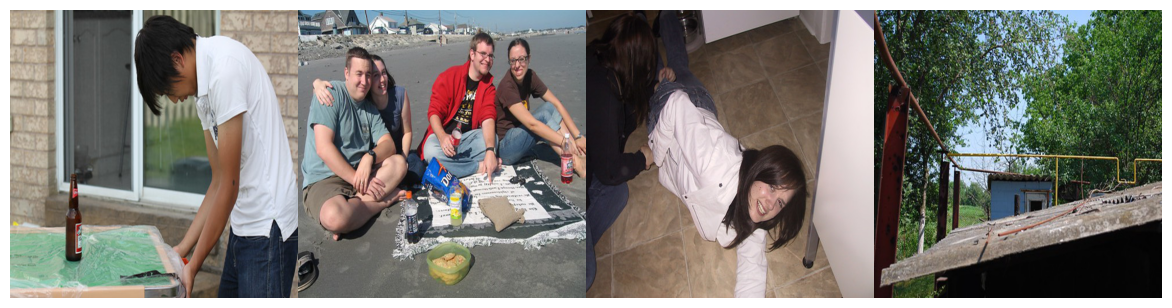

In [9]:
fig = plt.figure(figsize=(16, 48))
columns = 4
rows = 1

plt.figure()
query_image = query_image.resize((512,512))
plt.subplot(rows, columns, 1)
plt.imshow(query_image)
plt.grid(False);
plt.axis('off');

for index, i in enumerate(results):
    img_url = train_images[i]
    try:
        frame = Image.open(requests.get(img_url, stream=True).raw)
    except:
        print(f"Failed to load image {img_url}")
        continue
    img = frame.resize((512,512))
    plt.subplot(rows, columns, index+2)

    plt.imshow(img)
    plt.grid(False);
    plt.axis('off');

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1.8, bottom=0, top=0.8)
plt.show()